In [62]:
import jax.numpy as jnp
import numpy as np
import jax
from flax import nnx
import optax
from flax.training import train_state
import scipy
from scipy.spatial.distance import cdist
from scipy.integrate import RK45
import matplotlib.pyplot as plt

seed = 42
np.random.seed(42)


generate dataset:

$\frac{ds(x)}{dx} = g(s(x), u(x), x), x \in [0,1]$, $s(0) = 0$


goal: predict $s(x)$ over whole domain $[0,1]$ for any $u(x)$ 

this is basically learning the integration operator $u(x) \rightarrow s(x) = \int_0^x u(\tau)d\tau$

In [63]:
# kernel for gaussian random field function
def rbf_kernel(X, Y, length_scale = 1.0, variance = 1.0):
    dists = cdist(X, Y, metric = 'sqeuclidean')
    return variance * np.exp(-0.5 * dists/ length_scale ** 2)

# sample from gaussian random field, how you generate random initial conditions
# n_points = smoothness on domain [0,1], length_scale controls smoothness
def sample_grf(n_points = 100, n_dims = 1, length_scale = 1.0, variance = 1.0, n_samples = 5, random_state = seed):
    rng = np.random.default_rng(random_state)
    if n_dims == 1:
        X = np.linspace(0, 1, n_points)[:, None]
    else:
        X = rng.uniform(0, 1, size = (n_points, n_dims))

    K = rbf_kernel(X,X, length_scale = length_scale, variance = variance)
    samples = rng.multivariate_normal(mean = np.zeros(n_points), cov = K, size = n_samples)
    return X, samples

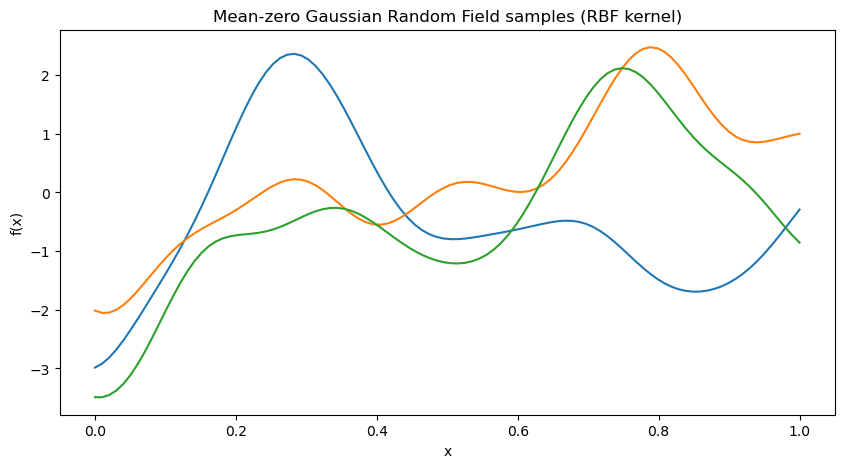

In [64]:
x, samples = sample_grf(n_points = 100, n_dims = 1, length_scale= 0.1, variance = 2.0, n_samples = 3, random_state = seed)
plt.figure(figsize=(10, 5))
for s in samples:
    plt.plot(x, s)
plt.title("Mean-zero Gaussian Random Field samples (RBF kernel)")
plt.xlabel("x")
plt.ylabel("f(x)")
plt.show()

could also potentially get ICs sampling from space of Chebyshev 1st kind polynomials

In [65]:
from scipy.integrate import solve_ivp
from scipy.interpolate import interp1d

u = samples[0]
x = x.reshape(-1)

u_interp = interp1d(x,u, kind="cubic", fill_value = "extrapolate")

def rhs(x,F):
    return u_interp(x) # dF/dx = u(x)

sol = solve_ivp(rhs, [0, 1], [0], method = "RK45", t_eval = x)

In [66]:
F_rk45 = sol.y[0]

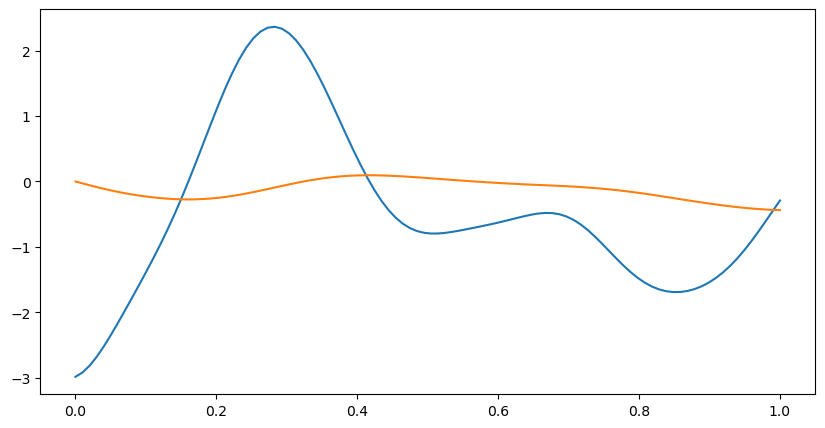

In [67]:
plt.figure(figsize=(10, 5))
plt.plot(x, u)
plt.plot(x, F_rk45)

bulk dataset generation

In [68]:
n_traj = 1000 # number of initial conditions
n_points = 100 # number of samples on domain
from scipy.integrate import cumulative_trapezoid


# samples are u(x)
x, samples = sample_grf(n_points = 100, n_dims = 1, length_scale= 0.1, variance = 2.0, n_samples = n_traj, random_state = seed)
x = x.reshape(-1)

integrals = np.zeros_like(samples) # preallocate memory


for i in range(n_traj):
    u = samples[i]
    F = cumulative_trapezoid(u,x, initial = 0)
    integrals[i] = F

print("samples shape:", samples.shape)
print("integrals shape:", integrals.shape)

samples shape: (1000, 100)
integrals shape: (1000, 100)


In [69]:
# Repeat x across all trajectories: shape (n_traj, n_points)
x_tiled = np.tile(x, (n_traj, 1))

# Stack along the last axis → (n_traj, n_points, 3)
dataset = np.stack([x_tiled, samples, integrals], axis=-1)

print(dataset.shape)  # (1000, 100, 3)

# Example: dataset[i,j] = [x_j, u_i(x_j), F_i(x_j)]
print(dataset[0,0])   # first traj, first point

(1000, 100, 3)
[ 0.         -2.98544719  0.        ]


In [70]:
print(dataset[0,:,:])

[[ 0.00000000e+00 -2.98544719e+00  0.00000000e+00]
 [ 1.01010101e-02 -2.91907129e+00 -2.98208004e-02]
 [ 2.02020202e-02 -2.81428317e+00 -5.87771361e-02]
 [ 3.03030303e-02 -2.67826828e+00 -8.65172950e-02]
 [ 4.04040404e-02 -2.51862342e+00 -1.12764223e-01]
 [ 5.05050505e-02 -2.34254782e+00 -1.37315593e-01]
 [ 6.06060606e-02 -2.15614377e+00 -1.60036257e-01]
 [ 7.07070707e-02 -1.96390460e+00 -1.80844582e-01]
 [ 8.08080808e-02 -1.76844277e+00 -1.99694822e-01]
 [ 9.09090909e-02 -1.57048231e+00 -2.16558080e-01]
 [ 1.01010101e-01 -1.36910471e+00 -2.31404479e-01]
 [ 1.11111111e-01 -1.16220474e+00 -2.44188870e-01]
 [ 1.21212121e-01 -9.47089871e-01 -2.54841873e-01]
 [ 1.31313131e-01 -7.21135148e-01 -2.63267252e-01]
 [ 1.41414141e-01 -4.82410703e-01 -2.69345766e-01]
 [ 1.51515152e-01 -2.30195926e-01 -2.72944790e-01]
 [ 1.61616162e-01  3.46732324e-02 -2.73932278e-01]
 [ 1.71717172e-01  3.09660452e-01 -2.72193219e-01]
 [ 1.81818182e-01  5.90591807e-01 -2.67646490e-01]
 [ 1.91919192e-01  8.71901402e-